In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [2]:
boc = BrainObservatoryCache(manifest_file='/local1/data/boc/manifest.json',)

In [3]:
oeid = 541206592

# Initializations:
nwb_dataset = boc.get_ophys_experiment_data(oeid)

# Get Data:
timestamps, dff = nwb_dataset.get_dff_traces()
neuron_ids = nwb_dataset.get_cell_specimen_ids()

In [4]:
import pandas as pd
traces = pd.DataFrame(
    dff.T,
    columns=neuron_ids,
    index=timestamps,
)

print(traces.tail())

            541510267  541510270  541510307  541510405  588381938  541510410  \
3795.81159  -0.008279   0.003694   0.050467   0.006070  -0.042818   0.012401   
3795.84476  -0.047829   0.058493  -0.021686   0.018117  -0.038725   0.050487   
3795.87794   0.010168  -0.024952   0.047753   0.072545  -0.047447   0.004467   
3795.91111  -0.066454  -0.020247   0.053140   0.028778  -0.014109  -0.022748   
3795.94429   0.011435   0.096762  -0.006261  -0.018426   0.026748   0.065441   

            541511183  541510394  588381886  541511196    ...      588381999  \
3795.81159   0.009308  -0.030401  -0.022308   0.030732    ...       0.055724   
3795.84476   0.009110   0.042929  -0.023901   0.007453    ...      -0.056759   
3795.87794  -0.037506   0.020595   0.019189   0.077029    ...       0.018929   
3795.91111   0.014085   0.000569   0.040021   0.040235    ...      -0.131435   
3795.94429   0.042813  -0.025608  -0.007862   0.076943    ...      -0.033498   

            541510679  541509977  5415

In [101]:
#############################################
# Next, we'll load epochs

epochs = nwb_dataset.get_stimulus_table('natural_scenes')
print(epochs.head())

#############################################
# The epochs lists stimulus times in terms of the start and end frames of
# the calcium traces, but we need start times and durations for neuroglia, so
# we'll need to reshape

epochs['time'] = timestamps[epochs['start']] + 0.1
epochs['duration'] = 0.5

epochs.rename(columns={'frame':'image_id'},inplace=True)

epochs = epochs[epochs['image_id']>=0]

print(epochs.head())

####################################
# We can get the average elicited spike count with the `ResponseReducer`

from neuroglia.epoch import EpochTraceReducer
import numpy as np
reducer = EpochTraceReducer(traces=traces,func=np.mean)
responses = reducer.fit_transform(epochs)
print(responses.head())

   frame  start    end
0     92  16125  16132
1     27  16133  16140
2     52  16140  16147
3     37  16148  16155
4    103  16155  16162
   image_id  start    end       time  duration
0        92  16125  16132  545.29658       0.5
1        27  16133  16140  545.56195       0.5
2        52  16140  16147  545.79416       0.5
3        37  16148  16155  546.05953       0.5
4       103  16155  16162  546.29174       0.5
           541510267  541510270  541510307  541510405  588381938  541510410  \
time                                                                          
545.29658   0.058292   0.068429   0.051853   0.008764   0.106076   0.036484   
545.56195   0.073360   0.071688   0.045226  -0.003462   0.089385   0.035545   
545.79416   0.051901   0.033619   0.022081  -0.005889   0.050934   0.026966   
546.05953   0.037321   0.019387   0.017736  -0.003050   0.038106   0.025693   
546.29174   0.025841   0.018571   0.042617  -0.021718   0.049283   0.026685   

           541511183  5415

In [102]:
from pyentropy import quantise

In [103]:
vector = responses[541510267].values
print vector

[ 0.05829171  0.07336037  0.05190103 ..., -0.00184361  0.00682828
 -0.00736815]


In [104]:
from pyentropy import utils

In [134]:
def bin_responses(vector):
    bins, _ = utils.quantise(vector.values,2,uniform='sampling',centers=False)
    return bins

In [135]:
quantised_responses = responses.apply(bin_responses,axis=0)
# X.apply along_axis(lambda v: len(v),axis=0)axis=1)

In [136]:
quantised_responses.head()

,541510267,541510270,541510307,541510405,588381938,541510410,541511183,541510394,588381886,541511196,...,588381999,541510679,541509977,541510142,541509981,541509952,541510950,541511172,541509957,541511118
time,,,,,,,,,,,,,,,,,,,,,
545.29658,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,0,1,1,1,1,1
545.56195,1,1,1,0,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
545.79416,1,1,1,0,1,1,0,1,1,1,...,1,1,1,0,1,1,1,1,1,1
546.05953,1,1,1,0,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
546.29174,1,1,1,0,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [137]:
from pyentropy import DiscreteSystem

def mutual_info(response,stimulus,shuffle=False):
    
    X = response.values.T.astype(np.int)
    X = np.atleast_2d(X)
    X_dims = (
        X.shape[0], # number of neurons
        X.max()+1, # alphabet size
    )
    
    Y = stimulus.values.astype(np.int)
    
    if shuffle:
        Y = np.random.permutation(Y)
    Y = np.atleast_2d(Y)
    Y_dims = (
        1, # number of stimulus conditions
        Y.max()+1, # alphabet size 
    )
    
    system = DiscreteSystem(X, X_dims, Y, Y_dims)
    system.calculate_entropies(method='pt', calc=['HX', 'HXY'])
    return system.I()

In [138]:
mutual_info(quantised_responses[541510267],epochs['image_id'])

0.01400362286111978

In [139]:
mi = quantised_responses.apply(
    lambda r: mutual_info(r,epochs['image_id']),
    axis=0,
)

In [140]:
%matplotlib inline
import seaborn as sns
sns.set_style('white')

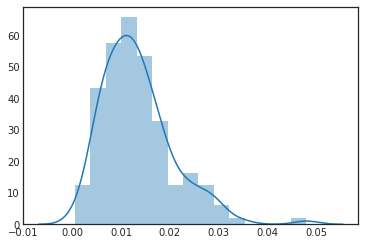

In [141]:
sns.distplot(mi)

In [142]:
mi_null = quantised_responses.apply(
    lambda r: mutual_info(r,epochs['image_id'],shuffle=True),
    axis=0,
)

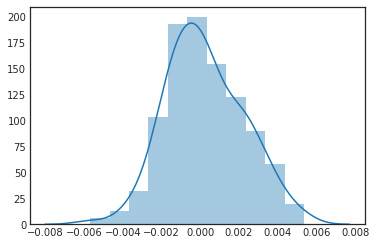

In [143]:
sns.distplot(mi_null)

In [144]:
neuron_stimulus_info = pd.DataFrame({'mutual_info':mi,'mutual_info_null':mi_null})

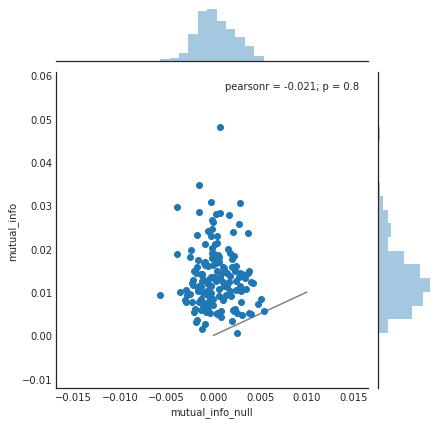

In [145]:
jp = sns.jointplot(x='mutual_info_null',y='mutual_info',data=neuron_stimulus_info)
jp.ax_joint.plot([0,0.01],[0,0.01],color='0.5',zorder=-100)

In [156]:
experiments = pd.DataFrame(boc.get_ophys_experiments(stimuli=['natural_scenes',])).set_index('id')
experiments.head()

,acquisition_age_days,cre_line,donor_name,experiment_container_id,fail_eye_tracking,imaging_depth,reporter_line,session_type,specimen_name,targeted_structure
id,,,,,,,,,,
511458874,72,Rbp4-Cre_KL100,234584,511511089,True,375,Ai93(TITL-GCaMP6f),three_session_B,Rbp4-Cre;Camk2a-tTA;Ai93-234584,VISl
562296530,129,Emx1-IRES-Cre,276949,561463418,False,175,Ai93(TITL-GCaMP6f),three_session_B,Emx1-IRES-Cre;Camk2a-tTA;Ai93-276949,VISpm
571099190,144,Cux2-CreERT2,283278,570994450,False,175,Ai93(TITL-GCaMP6f),three_session_B,Cux2-CreERT2;Camk2a-tTA;Ai93-283278,VISam
503772253,103,Cux2-CreERT2,225037,511510822,True,175,Ai93(TITL-GCaMP6f),three_session_B,Cux2-CreERT2;Camk2a-tTA;Ai93-225037,VISpm
580124131,93,Rbp4-Cre_KL100,300663,580051757,False,375,Ai93(TITL-GCaMP6f),three_session_B,Rbp4-Cre_KL100;Camk2a-tTA;Ai93-300663,VISrl


In [157]:
def compute_mutual_info(oeid):
    nwb_dataset = boc.get_ophys_experiment_data(oeid)

    # Get Data:
    timestamps, dff = nwb_dataset.get_dff_traces()
    neuron_ids = nwb_dataset.get_cell_specimen_ids()
    
    traces = pd.DataFrame(
        dff.T,
        columns=neuron_ids,
        index=timestamps,
    )

    
    epochs = nwb_dataset.get_stimulus_table('natural_scenes')

    epochs['time'] = timestamps[epochs['start']] + 0.1
    epochs['duration'] = 0.5

    epochs.rename(columns={'frame':'image_id'},inplace=True)

    epochs = epochs[epochs['image_id']>=0]
    
    reducer = EpochTraceReducer(traces=traces,func=np.mean)
    responses = reducer.fit_transform(epochs)
    
    quantised_responses = responses.apply(bin_responses,axis=0)
    
    mi = quantised_responses.apply(
        lambda r: mutual_info(r,epochs['image_id']),
        axis=0,
    )

    mi_null = quantised_responses.apply(
        lambda r: mutual_info(r,epochs['image_id'],shuffle=True),
        axis=0,
    )
    
    neuron_stimulus_info = pd.DataFrame({'mutual_info':mi,'mutual_info_null':mi_null})
    neuron_stimulus_info['oeid'] = oeid
    
    return neuron_stimulus_info

In [158]:
compute_mutual_info(oeid)

,mutual_info,mutual_info_null,oeid
541510267,0.014004,-0.003344,541206592
541510270,0.008080,0.000317,541206592
541510307,0.019990,-0.001444,541206592
541510405,0.003063,0.000883,541206592
588381938,0.006258,-0.000768,541206592
541510410,0.011133,0.001918,541206592
541511183,0.000583,0.002678,541206592
541510394,0.017470,-0.001598,541206592
588381886,0.014447,0.000750,541206592
541511196,0.012479,-0.000083,541206592


In [ ]:
mi_data = []
for oeid in experiments.index:
    neuron_stimulus_info = compute_mutual_info(oeid)
    mi_data.append(neuron_stimulus_info)
    

In [160]:
mi_data = pd.concat(mi_data)

In [164]:
experiments

,acquisition_age_days,cre_line,donor_name,experiment_container_id,fail_eye_tracking,imaging_depth,reporter_line,session_type,specimen_name,targeted_structure
id,,,,,,,,,,
511458874,72,Rbp4-Cre_KL100,234584,511511089,True,375,Ai93(TITL-GCaMP6f),three_session_B,Rbp4-Cre;Camk2a-tTA;Ai93-234584,VISl
562296530,129,Emx1-IRES-Cre,276949,561463418,False,175,Ai93(TITL-GCaMP6f),three_session_B,Emx1-IRES-Cre;Camk2a-tTA;Ai93-276949,VISpm
571099190,144,Cux2-CreERT2,283278,570994450,False,175,Ai93(TITL-GCaMP6f),three_session_B,Cux2-CreERT2;Camk2a-tTA;Ai93-283278,VISam
503772253,103,Cux2-CreERT2,225037,511510822,True,175,Ai93(TITL-GCaMP6f),three_session_B,Cux2-CreERT2;Camk2a-tTA;Ai93-225037,VISpm
580124131,93,Rbp4-Cre_KL100,300663,580051757,False,375,Ai93(TITL-GCaMP6f),three_session_B,Rbp4-Cre_KL100;Camk2a-tTA;Ai93-300663,VISrl
570909395,126,Nr5a1-Cre,286366,570428250,False,350,Ai93(TITL-GCaMP6f),three_session_B,Nr5a1-Cre;Camk2a-tTA;Ai93-286366,VISrl
570006683,139,Cux2-CreERT2,282820,569287964,False,175,Ai93(TITL-GCaMP6f),three_session_B,Cux2-CreERT2;Camk2a-tTA;Ai93-282820,VISam
568775666,126,Cux2-CreERT2,282817,565216521,False,175,Ai93(TITL-GCaMP6f),three_session_B,Cux2-CreERT2;Camk2a-tTA;Ai93-282817,VISam
548227481,113,Emx1-IRES-Cre,260936,547315012,True,175,Ai93(TITL-GCaMP6f),three_session_B,Emx1-IRES-Cre;Camk2a-tTA;Ai93-260936,VISl


In [168]:
mi_data = mi_data.merge(experiments,left_on='oeid',right_index=True)

In [175]:
mi_data['depth'] = mi_data['imaging_depth'].map(lambda x: np.floor(x/100)*100)

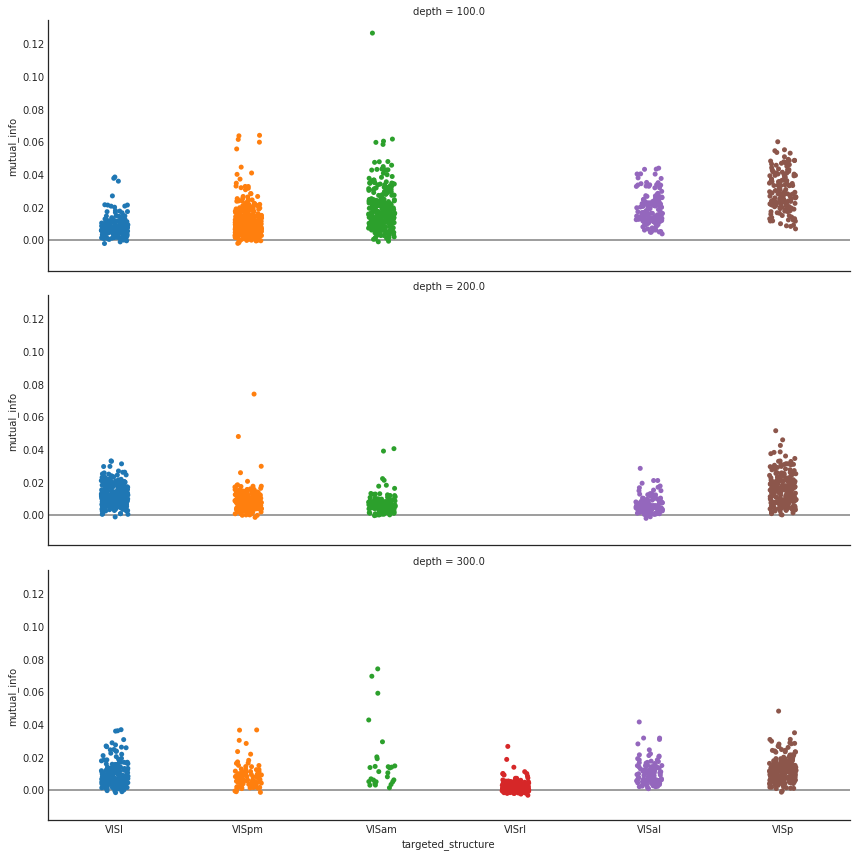

In [190]:
g = sns.factorplot('targeted_structure','mutual_info',data=mi_data,
#                    hue='cre_line',
                   row='depth',
                   aspect=3,
                   kind='strip',
                   jitter=True
                  )
for ax in g.axes.flatten():
    ax.axhline(0.0,color='0.5')

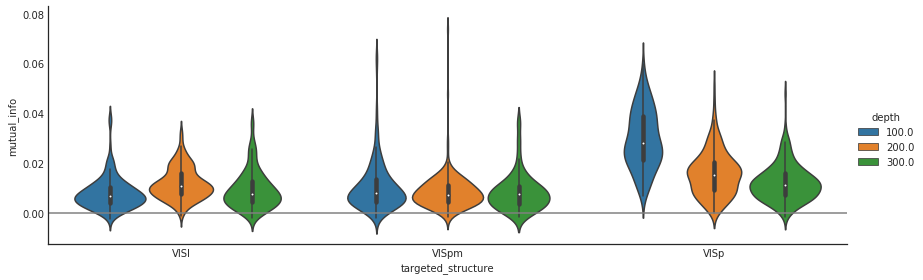

In [188]:
mask = (
    (mi_data['targeted_structure'].isin(['VISp','VISl','VISpm']))
)

g = sns.factorplot('targeted_structure','mutual_info',data=mi_data[mask],
#                    hue='cre_line',
                   hue='depth',
                   aspect=3,
                   kind='violin',
#                    jitter=True
                  )
for ax in g.axes.flatten():
    ax.axhline(0.0,color='0.5')

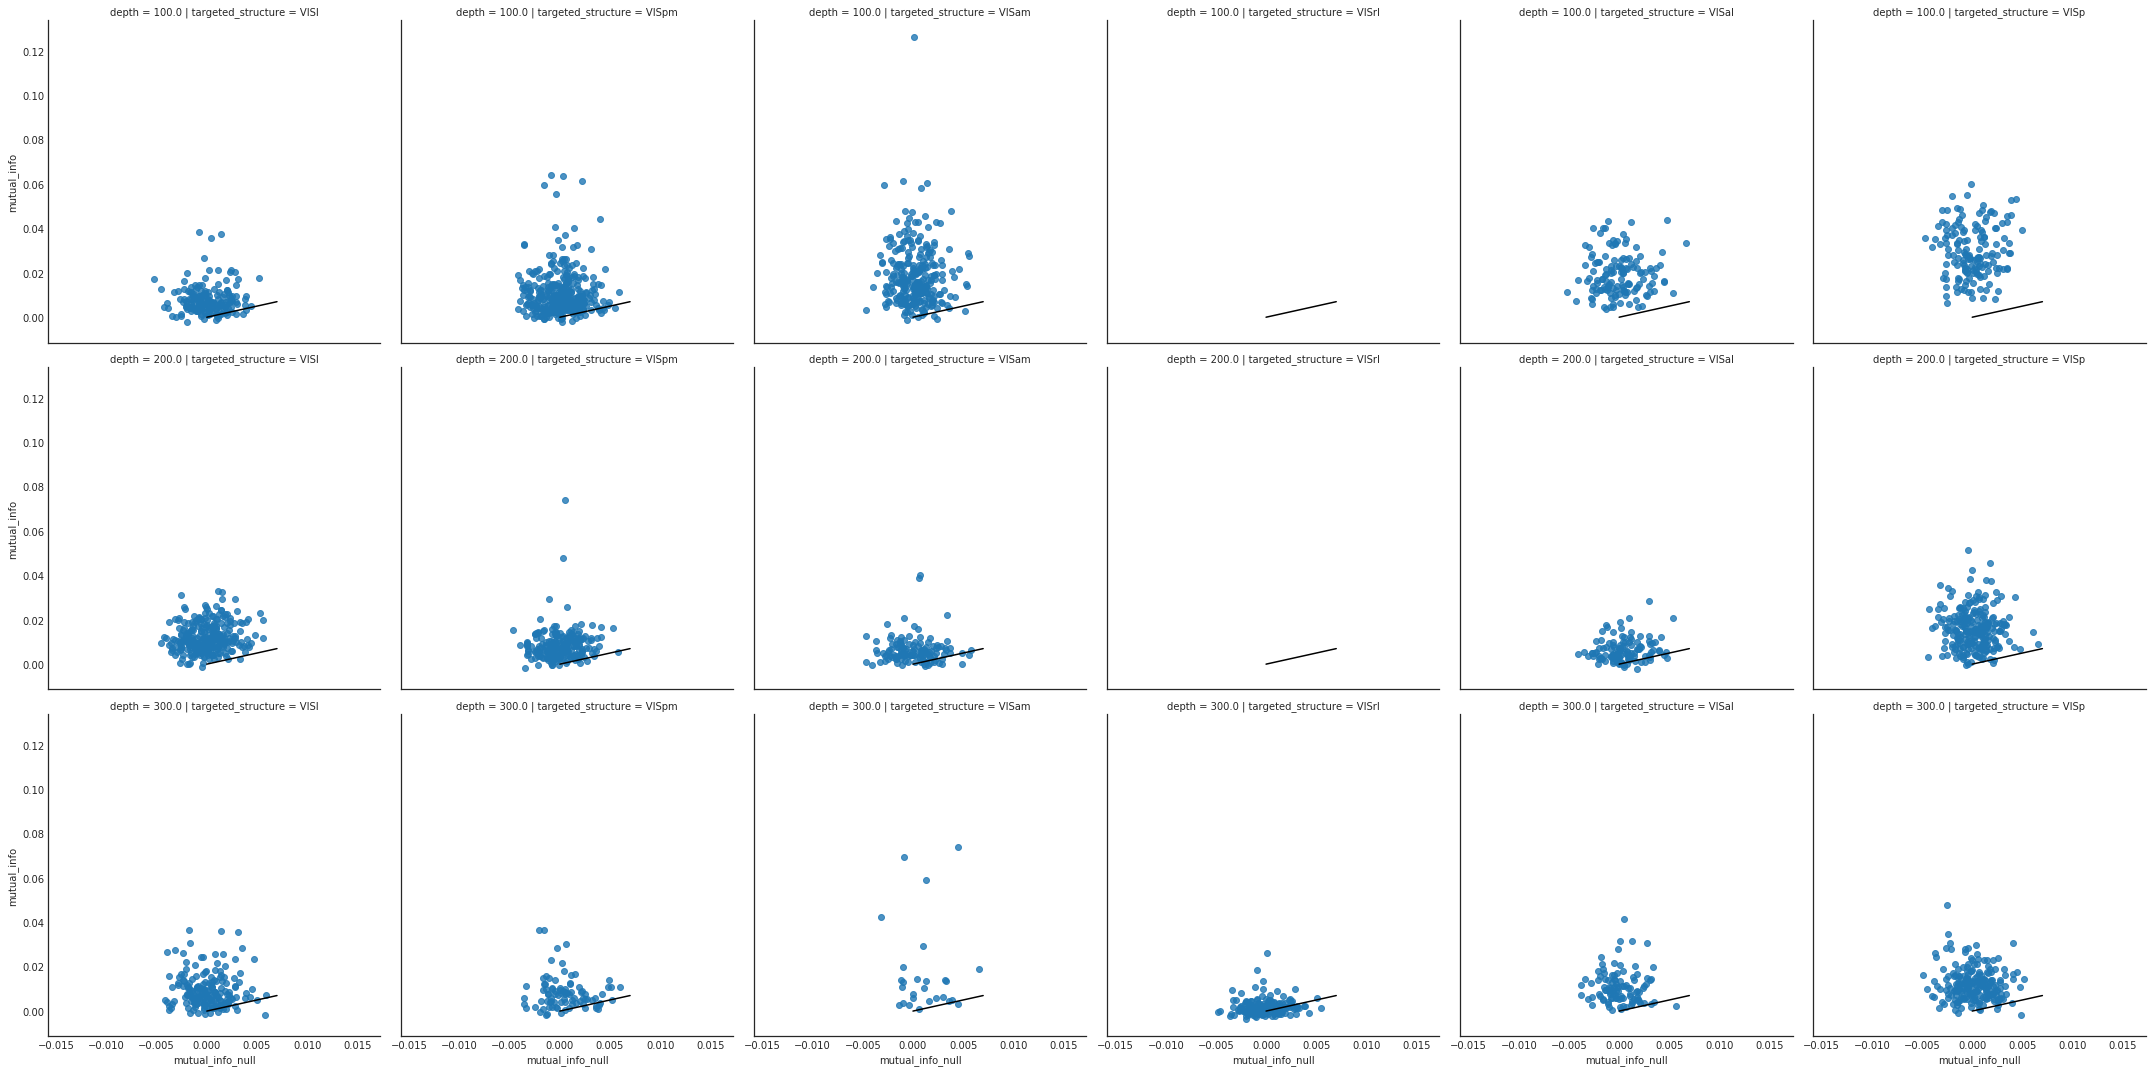

In [189]:
g = sns.lmplot('mutual_info_null','mutual_info',data=mi_data,
#                hue='cre_line',
               col='targeted_structure',
               row='depth',
               fit_reg=False,
              )
for ax in g.axes.flatten():
    ax.plot([0,0.007],[0,0.007],color='k')